# Predicting Heart Disease with Supervised Machine Learning

The World Health Organization (WHO) estimates that [17.9 million people die from cardiovascular diseases (CVDs) every year](https://www.who.int/health-topics/cardiovascular-diseases#tab=tab_1).

There are multiple risk factors that could contribute to CVD in an individual, such as unhealthy diet, lack of physical activity, or mental illness. Identifying these risk factors early on could help prevent many premature deaths.

We are working for an R&D company that focuses on providing healthcare solutions. The company has collected anonymized data from multiple hospitals on several patients. The [dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) includes relevant information for each patient, such as their personal information and some medical data, including whether or not they have had heart disease before.

We are tasked with using the dataset to accurately predict the likelihood of a new patient having heart disease in the future. The dataset has the following features:

- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

Before anything else, it would be beneficial to explore our data:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
style.use('fivethirtyeight')
%matplotlib inline

In [2]:
heart = pd.read_csv('heart_disease_prediction.csv')
print('First 5 rows: ','\n\n',heart.head(),'\n\n')
print('Row and column number: ','\n\n',heart.shape,'\n\n')
print('Column characteristics: ','\n\n',heart.describe(),'\n\n')
print(heart.info())

First 5 rows:  

    Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0   


Row and column number:  

 (918, 12) 


Column characteristics:  

               Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.

A few observations we can make immediately:

- Most columns are numerical, and the rest could potentially be transformed into binary format or made into dummie columns
    - FastingBS and HeartDisease already take only 0 or 1 as values
- HeartDisease is already in binary form
- We have 918 rows with 12 columns. None of the columns seem to have any null values 
- The average age of observed patients is 53
- The maximum heart rate shows some outliers with extremely low maximum heart rate
    - RestingBP and Cholesterol have minimums of 0
- Cholesterol seems to have significant variability
    - Its average is quite below the mean, indicating potentially a left skewed distribution
    
Low Cholesterol is good, but can it be zero? According to our dataset, the Cholesterol column includes the __serum cholesterol__ values, and according to the [American Heart Association](https://www.heart.org/en/health-topics/cholesterol/about-cholesterol/what-your-cholesterol-levels-mean), this is a '_...composite of different measurements. Your total blood cholesterol is calculated by adding your HDL and LDL cholesterol levels, plus 20% of your triglyceride level_'. Thus, a value of zero is not likely.

## Distributions Around Heart Disease

Before we can continue with our analysis, we should know more about our data and how it relates to our target column: HeartDisease. We will do so through visualizations of categorical columns.


In [3]:
heart.describe(include = ['object'])

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


Other than these above, we know that HeartDisease and FastingBS are also categorical. Let's check their distinct values to make sure they are binary:

In [4]:
heart['FastingBS'].unique()

array([0, 1])

In [5]:
heart['HeartDisease'].unique()

array([0, 1])

Now, let's explore categorical distributions more closely:

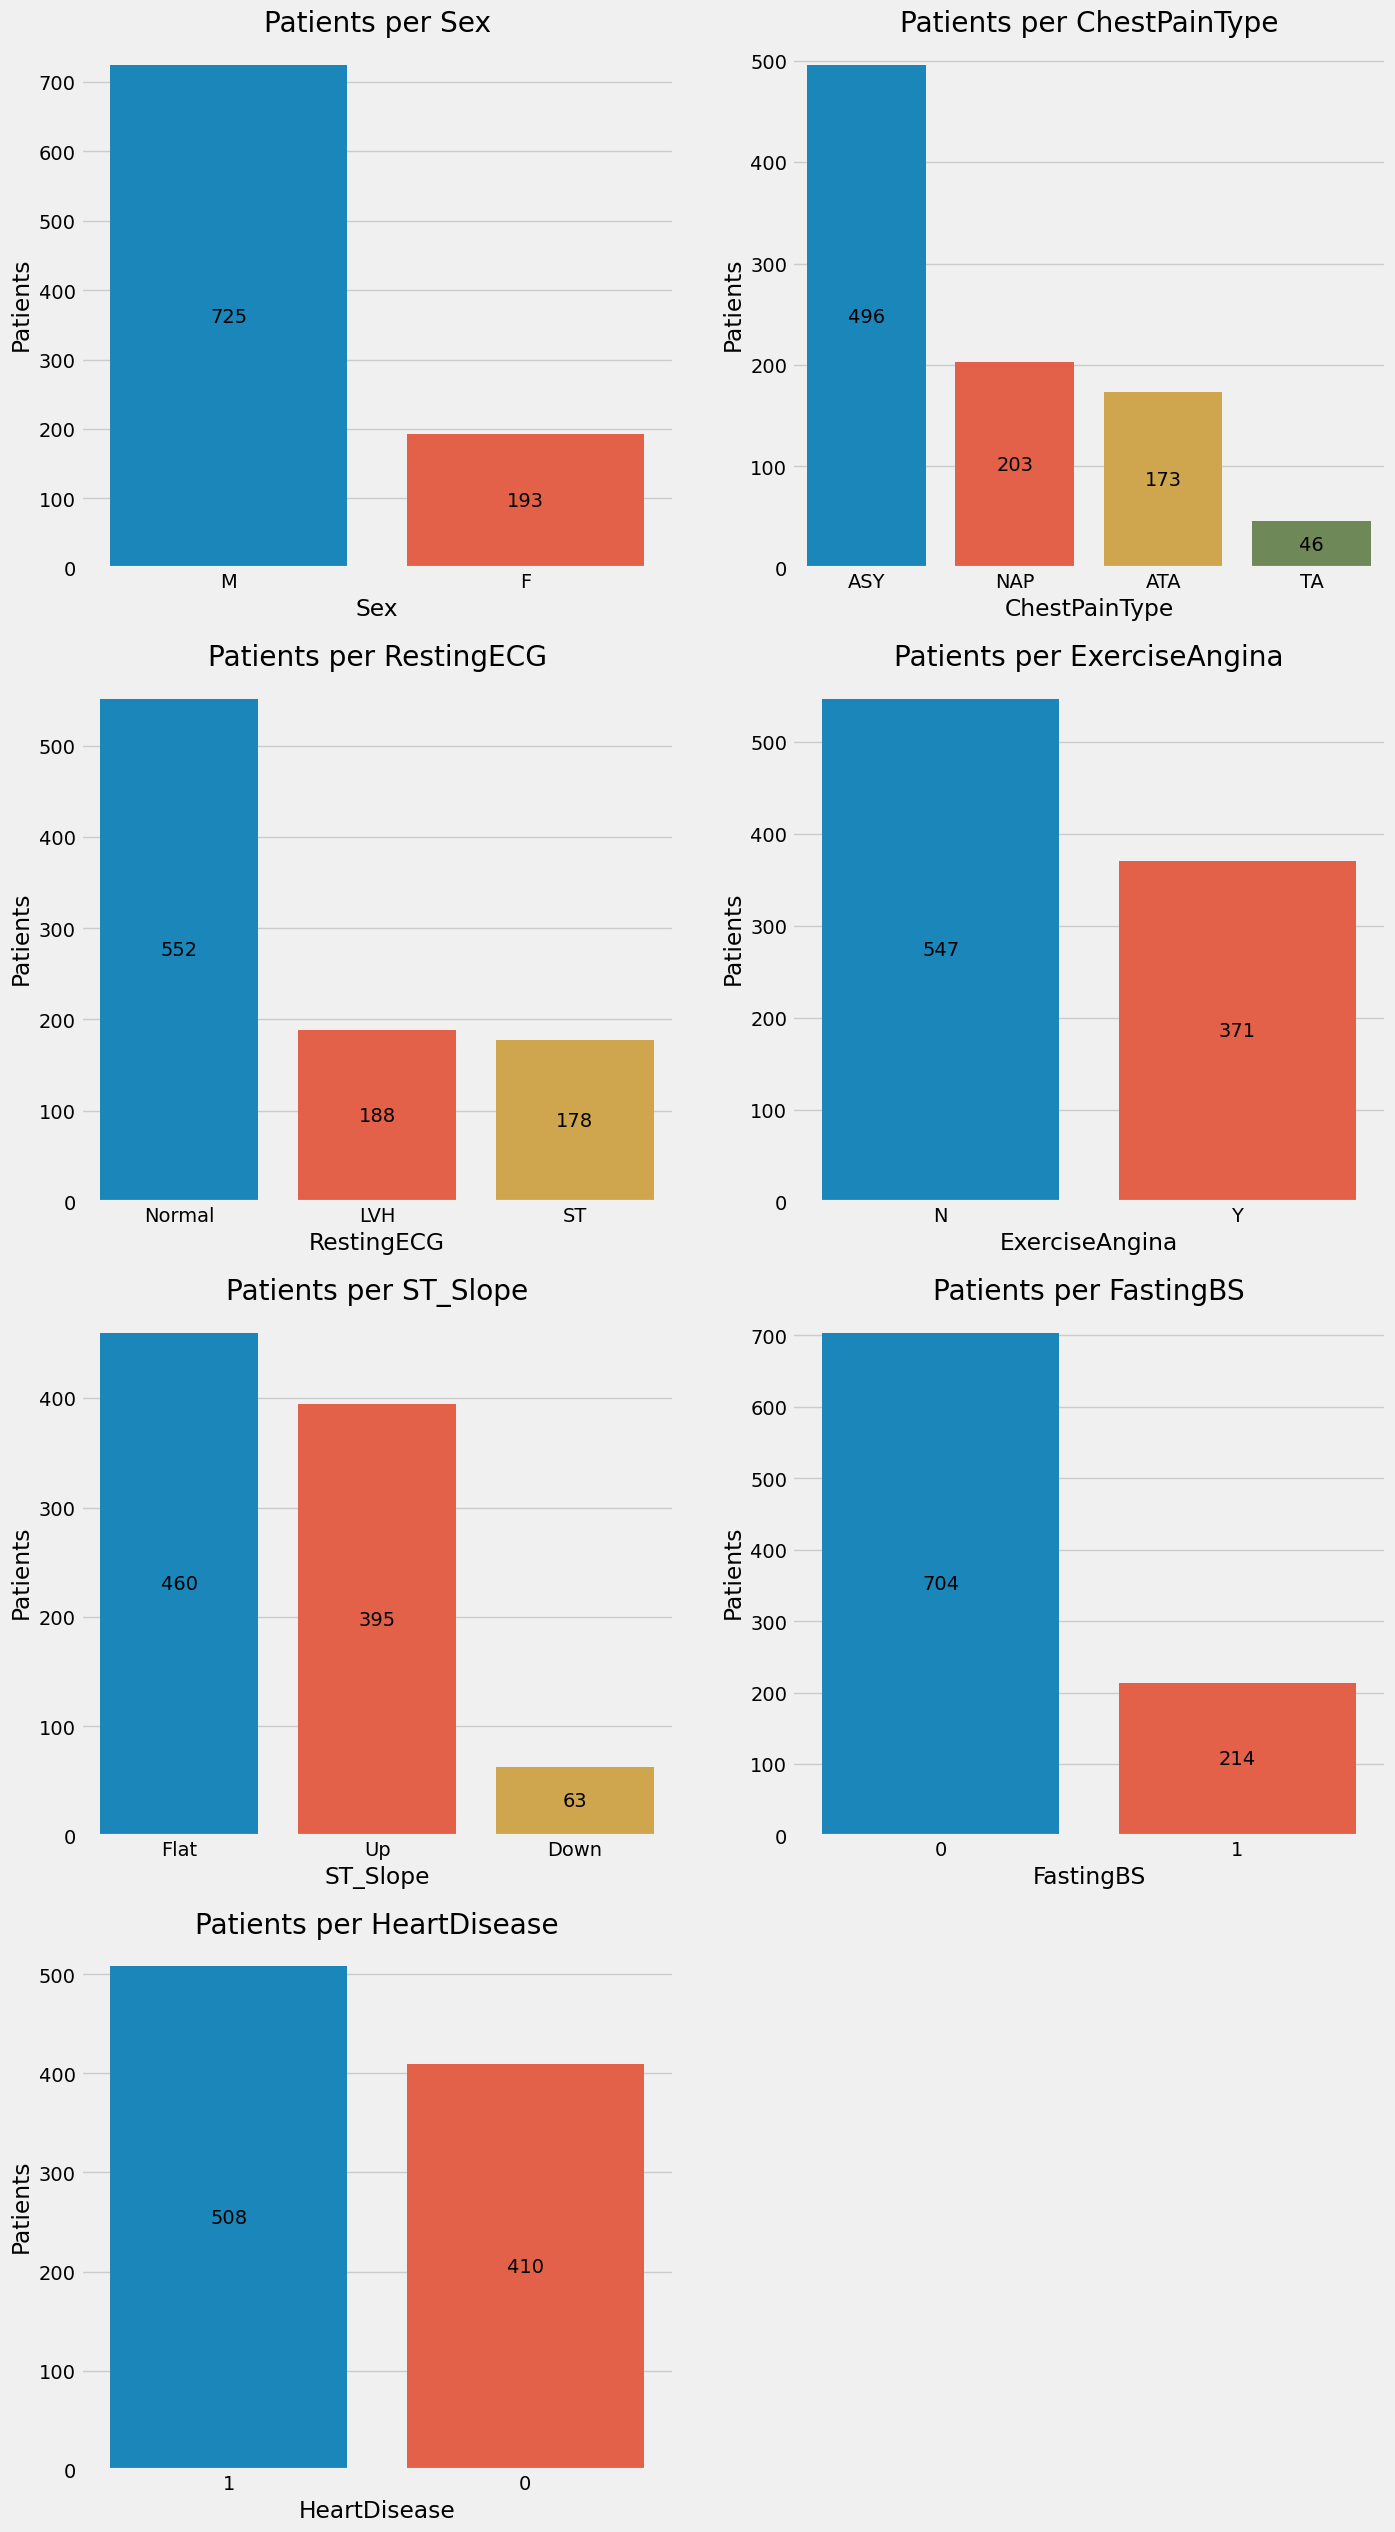

In [6]:
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS', 'HeartDisease']

figure = plt.figure(figsize = (15, 30))
for fig, category in zip(range(1,8), categorical_columns):
    ax = plt.subplot(4, 2, fig)
    sns.countplot(x = heart[category], 
                  ax = ax, 
                  order = heart[category].value_counts(ascending = False).index).set(title = 'Patients per {}'.format(category))
    for container in ax.containers:
        ax.bar_label(container, label_type="center")
        ax.set_ylabel('Patients')


- The dataset skews highly towards male patients, with 725 being male versus 193 females
- Over half of the patients have ASY Chest Pain Type
- Over half of the patients have Normal Resting ECG
- 704 of the patients had Fasting Blood Sugar lower than 120 mg/dl

To better understand how these columns relate to heart disease we can repeat the charts above, but this time we will group results by the HeartDisease column:

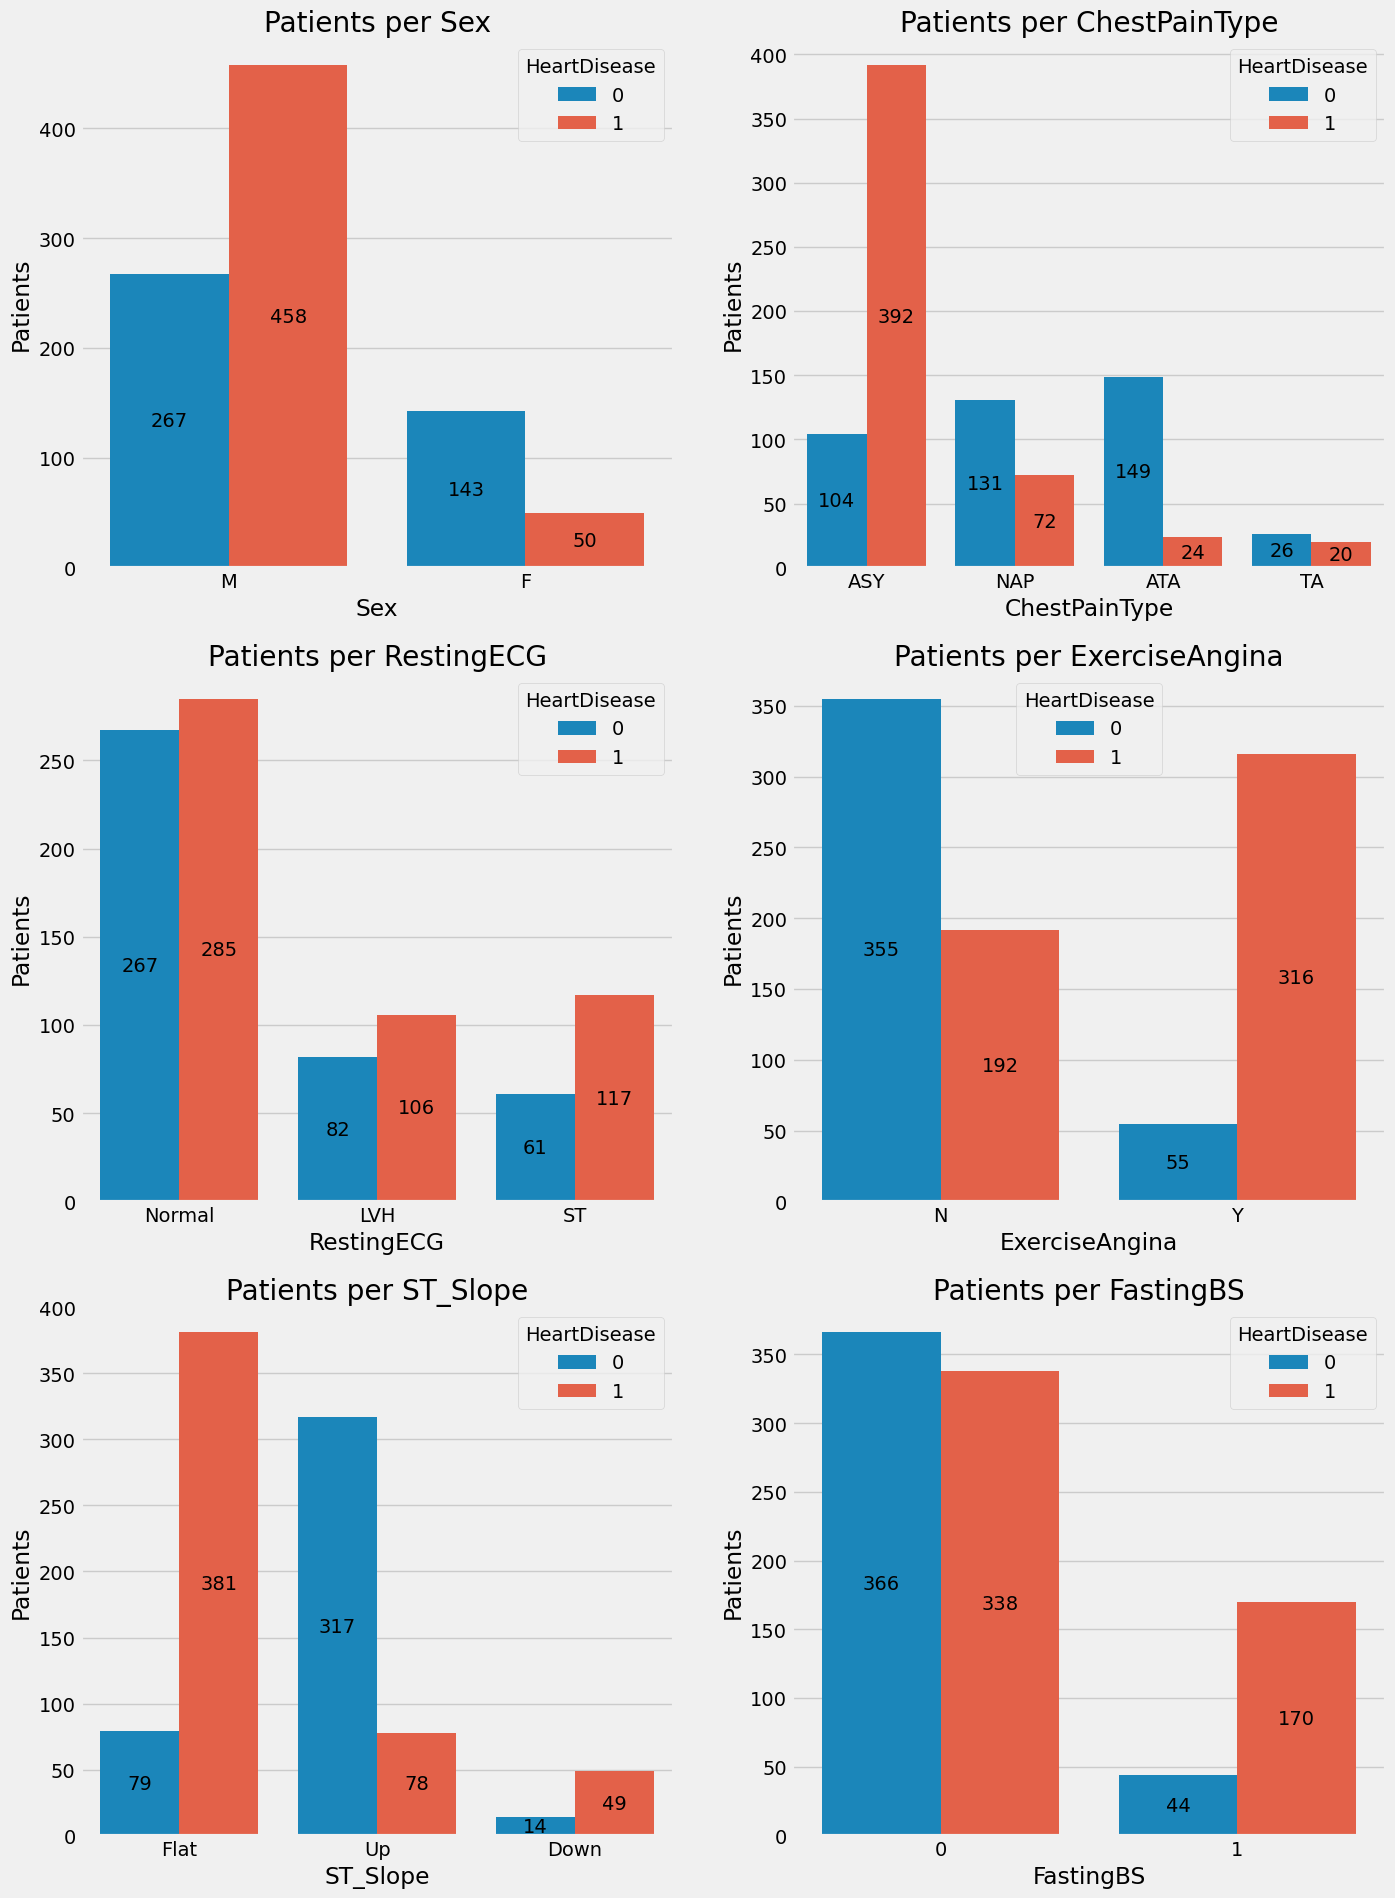

In [7]:
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS']

figure = plt.figure(figsize = (15, 30))
for fig, category in zip(range(1,7), categorical_columns):
    ax = plt.subplot(4, 2, fig)
    sns.countplot(x = heart[category], 
                  ax = ax, 
                  hue = heart['HeartDisease'],
                  order = heart[category].value_counts(ascending = False).index).set(title = 'Patients per {}'.format(category))
    for container in ax.containers:
        ax.bar_label(container, label_type="center")
        ax.set_ylabel('Patients')

After grouping by HeartDisease, we find that from our patient list the ones with the highest likelihood of having a heart disease are:
- Males, while the opposite is true for Females
- Patients with ASY Chest Pain Type
- Those with Exercise Angina
- People with Flat and Down ST Slope
- Patients with Fasting Blood Sugar higher than 120 mg/dl

## Data Cleaning

Above, we found that there are no null values in our data set. However, we know that RestingBP and Cholesterol should not have patients with 0 values. There's a few things we could do to these rows:

- We could remove those rows entirely if their frequency of occurrence is low.
- We could impute those zeros with the median value of that column or the median value of the column grouped by HeartDisease.
- We could try some complex approaches. For example, instead of using the median of the entire column, maybe we could look at the median of the values grouped by the age, sex, and/or resting ECG of the patient. The resting blood pressure of a female in her 30s with a normal ECG might be lower than what we would get from the median of the entire column.

Let's start by checking how many patients actually have a value of 0 for these columns:


In [8]:
restingBP_is_zero = heart['RestingBP'] == 0
cholesterol_is_zero = heart['Cholesterol'] == 0

print('There are {} patients with a Resting BP of zero.'.format(restingBP_is_zero.sum()))
print('There are {} patients with a Cholesterol level of zero.'.format(cholesterol_is_zero.sum()))
      

There are 1 patients with a Resting BP of zero.
There are 172 patients with a Cholesterol level of zero.


In [9]:
heart[restingBP_is_zero].head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


Since there is only one patient with a Resting BP level of zero, we can drop it. However, a significant portion of our data set has customers with a Cholesterol level of zero, so we should prevent dropping those. 

In [10]:
# dropping patients with resting bp of zero

heart = heart.drop(heart[restingBP_is_zero].index)
restingBP_is_zero = heart['RestingBP'] == 0
print('There are {} patients with a Resting BP of zero.'.format(restingBP_is_zero.sum()))

There are 0 patients with a Resting BP of zero.


With that out of the way, we will deal with cholesterol now. For this, we will find the median cholesterol level for patients grouped by their age, sex and resting ECG, since this would greatly differ by age groups as well.

To do this, we should begin by grouping the patients without cholesterol of 0 by age, sex and RestingBP:

In [11]:
# separate age into decades
heart['decade'] = heart['Age'].apply(lambda x: (x // 10) * 10)
print(heart['decade'].value_counts())

# separate resting bp into 20s
heart['resting_bp_groups'] = heart['RestingBP'].apply(lambda x: (x // 20) * 20)
print(heart['resting_bp_groups'].value_counts())

50    373
60    222
40    211
30     76
70     31
20      4
Name: decade, dtype: int64
120    430
140    234
100    148
160     73
180     16
80      12
200      4
Name: resting_bp_groups, dtype: int64


In [12]:
# create new data frame by removing those with 0 cholesterol

correct_cholesterol = heart[heart['Cholesterol'] != 0].copy()

In [13]:
# group patients by sex, decade and resting bp and find the median cholesterol

grouped_median_cholesterol = correct_cholesterol.groupby(['decade', 'Sex', 'resting_bp_groups'])['Cholesterol'].median().reset_index()
grouped_median_cholesterol = grouped_median_cholesterol.rename(columns = {'Cholesterol' : 'median_cholesterol'})
print(grouped_median_cholesterol.head(20))

    decade Sex  resting_bp_groups  median_cholesterol
0       20   M                120               204.0
1       20   M                140               263.0
2       30   F                 80               199.0
3       30   F                100               210.0
4       30   F                120               211.0
5       30   F                140               167.0
6       30   F                160               237.0
7       30   M                 80               168.5
8       30   M                100               248.5
9       30   M                120               241.0
10      30   M                140               239.0
11      30   M                160               147.0
12      30   M                180               241.0
13      40   F                100               209.5
14      40   F                120               236.5
15      40   F                140               240.5
16      40   F                160               180.0
17      40   F              

Before we proceed, let's make sure that there are no groups with a median cholesterol of 0.

In [14]:
# checking for groups with cholesterol of 0
grouped_zero_cholesterol = grouped_median_cholesterol['median_cholesterol'] == 0
print('There are {} groups with a median cholesterol of 0.'.format(grouped_zero_cholesterol.sum()))

There are 0 groups with a median cholesterol of 0.


In [15]:
# for patients with cholesterol of 0, merge on decade, sex and resting bp group
# once done, replace cholesterol value with median cholesterol and keep only original columns

wrong_cholesterol = heart[heart['Cholesterol'] == 0].copy()
wrong_cholesterol = pd.merge(wrong_cholesterol, grouped_median_cholesterol, on = ['decade', 'Sex', 'resting_bp_groups'], how = 'left')
wrong_cholesterol['Cholesterol'] = wrong_cholesterol['median_cholesterol']
wrong_cholesterol = wrong_cholesterol.drop(['decade', 'resting_bp_groups', 'median_cholesterol'], axis = 1)
correct_cholesterol = correct_cholesterol.drop(['decade', 'resting_bp_groups'], axis = 1)

Now that we obtained the median cholesterol for the relevant patients, we can merge that back to the patients with the correct cholesterol levels:

In [16]:
clean_heart = pd.concat([correct_cholesterol, wrong_cholesterol])
print(clean_heart.head())
print(clean_heart.shape)

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140        289.0          0     Normal    172   
1   49   F           NAP        160        180.0          0     Normal    156   
2   37   M           ATA        130        283.0          0         ST     98   
3   48   F           ASY        138        214.0          0     Normal    108   
4   54   M           NAP        150        195.0          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
(917, 12)


## Feature Selection

We have now cleaned up the columns with incorrect values and put them back together into our 'clean_heart' dataset. The next step is select which columns we are interested in using for our model training. From our understanding of the topic, we could start with:

- Age
- Sex
- ChestPainType
- Cholesterol
- FastingBS

Before anything, though, we should create dummie variable for our categorical columns:

In [17]:
clean_heart = pd.get_dummies(data = clean_heart, drop_first = True)
clean_heart.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289.0,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180.0,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283.0,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214.0,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195.0,0,122,0.0,0,1,0,1,0,1,0,0,0,1


With this done, we will get a Pearson's Correlation number between each column and 'HeartDisease', and this should help us start finding columns that could be valuable for this project:

<AxesSubplot:>

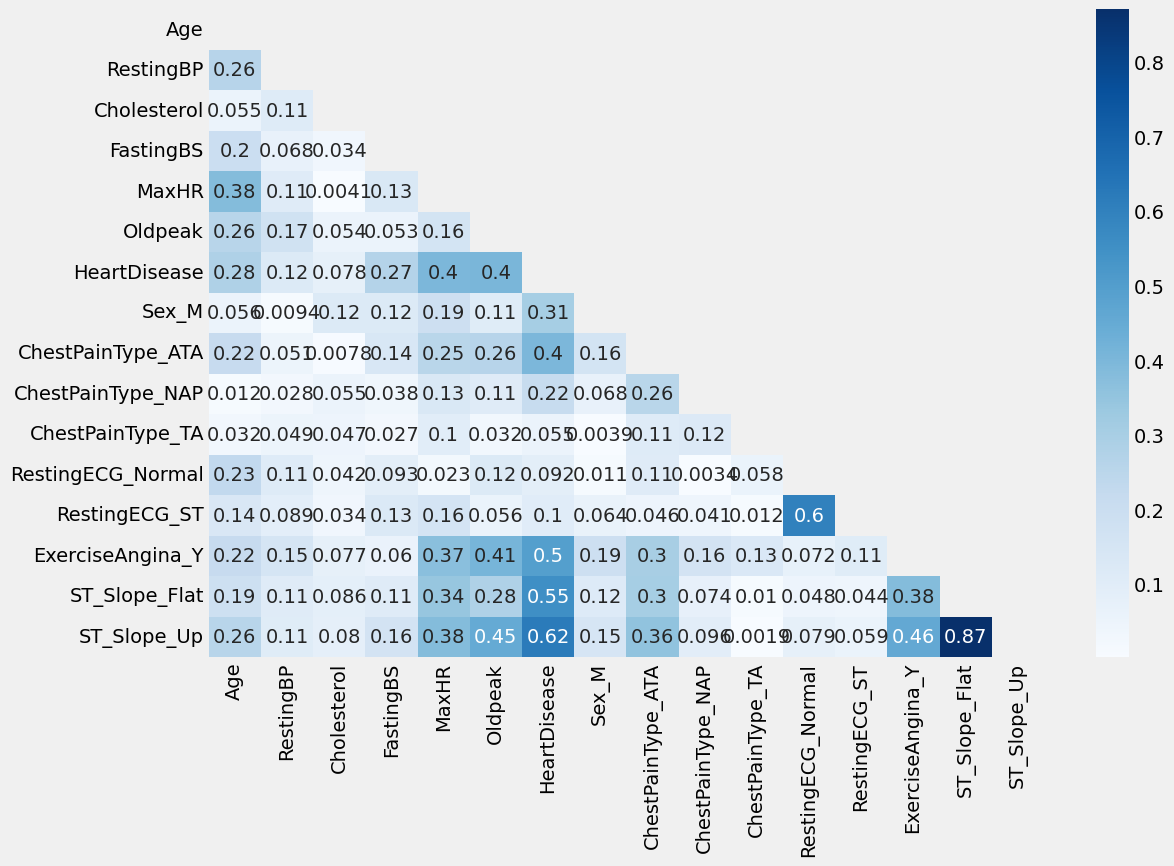

In [18]:
correlations = abs(clean_heart.corr())
mask = np.triu(np.ones_like(correlations, dtype=bool))
plt.figure(figsize=(12,8))
sns.heatmap(correlations, mask = mask, annot=True, cmap="Blues")

This is a lot lot look at, let us keep only the correlation values higher than 0.3:

<AxesSubplot:>

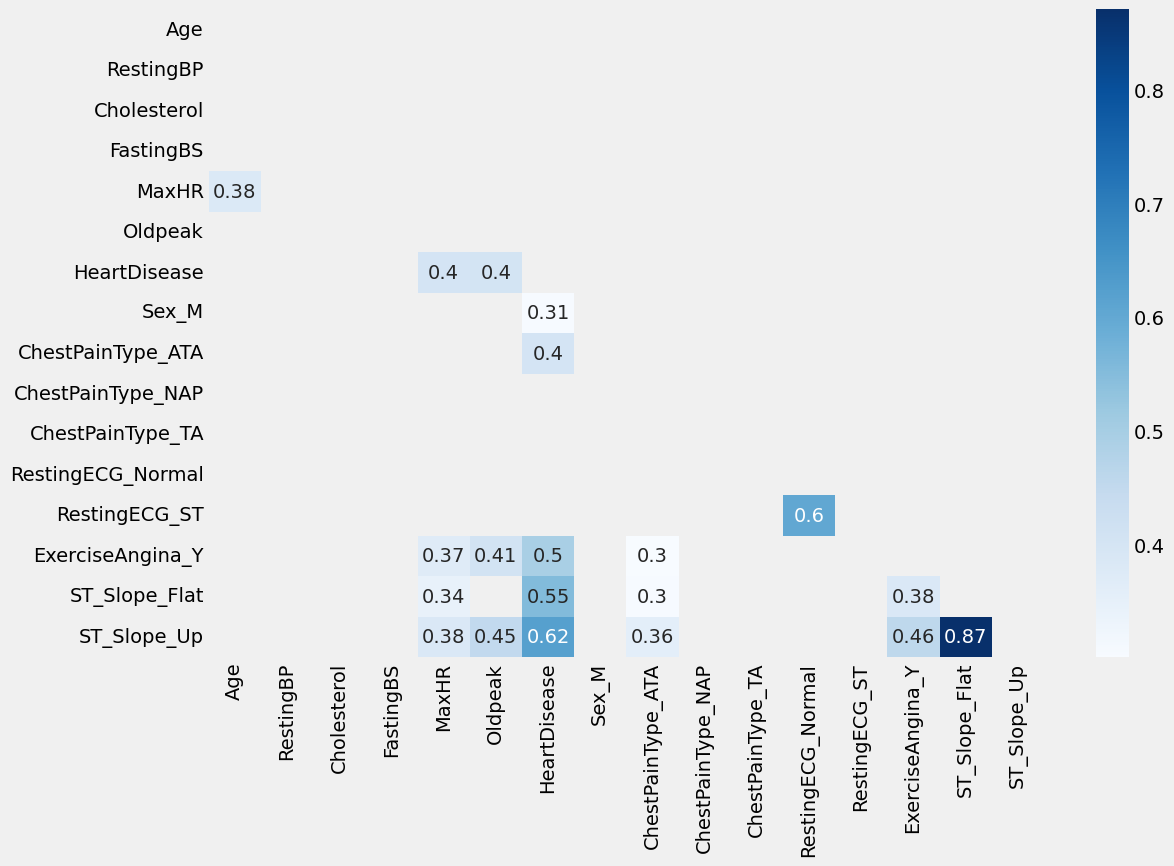

In [19]:
plt.figure(figsize=(12,8))
sns.heatmap(correlations[correlations > 0.3], mask = mask, annot=True, cmap="Blues")

From our correlation heat map, we find that the columns strongly correlated to HeartDisease are:

- Oldspeak
- MaxHR
- Sex_M (realtively low correlation, but let's keep it anyway given our exploratory analysis results)
- ChestPainType_ATA
- ExerciseAngina_Y
- ST_Slope_Flat
- St_Slope_Up

Surprisingly, we find that __Cholesterol is not strongly correlated with heart disease__.

Let's also take a look at the squared values of the Pearson correlation, for good measure:

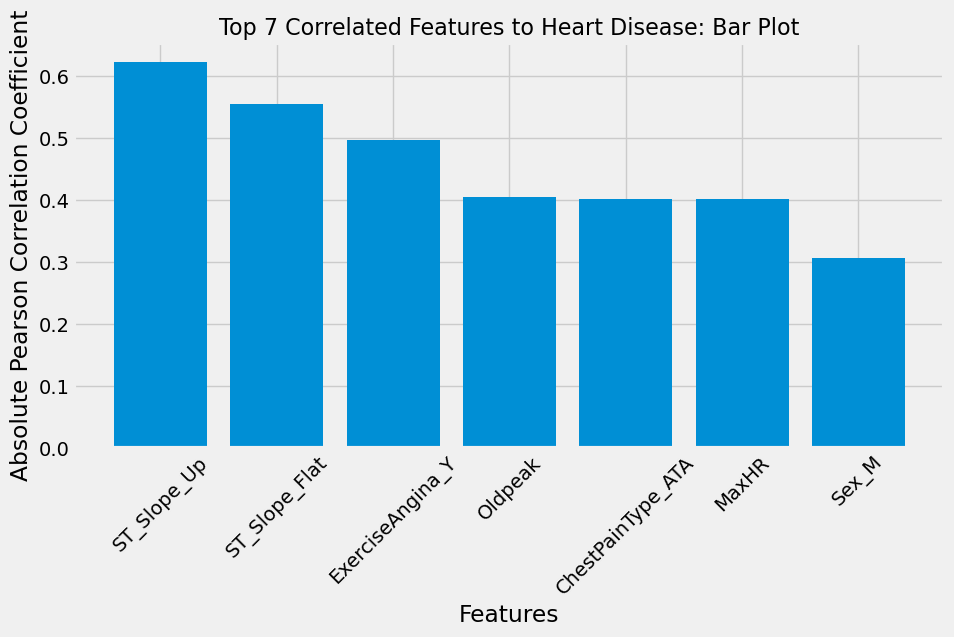

In [20]:
# Select top 7 features using square of the Pearson correlation
top_7_features = (correlations['HeartDisease'] ** 2).sort_values(ascending=False)[1:8].index.tolist()

# Create bar plot
plt.figure(figsize=(10, 5))
plt.bar(x=top_7_features, height=correlations.loc[top_7_features, 'HeartDisease'])
plt.xticks(rotation=45)
plt.title('Top 7 Correlated Features to Heart Disease: Bar Plot', fontsize=16)
plt.ylabel('Absolute Pearson Correlation Coefficient')
plt.xlabel('Features')
plt.show()

Given what we see here, we will exclude ChestPainType_ATA and MaxHR from our analysis for now, but we can always include them back in later on. Our final list of features is then:

- Oldpeak
- Sex_M 
- ExerciseAngina_Y
- ST_Slope_Flat
- St_Slope_Up

## Building a Single Feature Classifier with K Nearest Neighbors

Now that we have picked the features to use, we can proceed further. We will first split the dataset into a training and validation set, and then attempt to train a model using only one of the selected features at the time. This split will be an 85-15, so 779 and 136 patients respectively:

In [21]:
# split into features and target column
X = clean_heart.drop(['HeartDisease'], axis = 1)
y = clean_heart['HeartDisease']

# split into train and validation sets, create list of features and k neighbors
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.15, random_state = 417)
features = ['Oldpeak', 'Sex_M', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']
k_values = [1,2,3,4,5]

# dataframe to display results
accuracies = pd.DataFrame(columns = k_values, index = features)

# testing model accuracy with different features and kneighbor sizes
for feature in features:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train[[feature]], y_train)
        validation_accuracy = knn.score(X_val[[feature]], y_val)
        accuracies.at[feature, k] = validation_accuracy
        
print('Accuracies for the different feature and k-neighbor combinations:\n')
print(accuracies.head(10))

Accuracies for the different feature and k-neighbor combinations:

                         1         2         3         4         5
Oldpeak           0.630435  0.586957  0.724638  0.702899  0.724638
Sex_M             0.630435   0.42029  0.630435  0.630435  0.630435
ExerciseAngina_Y   0.73913   0.73913   0.73913   0.73913   0.73913
ST_Slope_Flat     0.797101   0.42029   0.42029   0.42029   0.42029
ST_Slope_Up       0.833333   0.42029  0.833333  0.833333  0.833333


When we use a single feature per iteration, and with different k values, we find that the model has the highest accuracy (__83.3%__) when using ST_Slope_Up, closely followed by ExerciseAngina_Y (__73.9%__). We will see what happens next when we use multiple features for training.

## Building a Multiple Feature Classifier with K Nearest Neighbors

We will next repeat the training of the model, but this time using multiple features for our model. Before we do this though, we need to normalize our features to a 0-1 scale using the MinMaxScaler function available in sklearn:

In [22]:
# Use a scaler to normalize all values to a 0-1 scale for our list of features
# transform features in the validation set
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_scaled, y_train)
knn_score = round((knn.score(X_val_scaled, y_val))*100,2)

print('When using all the selected features to train the model, we predicted the HeartDisease status of the validation set with {}% accuracy.'.format(knn_score))

When using all the selected features to train the model, we predicted the HeartDisease status of the validation set with 83.33% accuracy.


Using all the features we selected, we still got an __83.3%__ accuracy, so we saw no improvement versus training the data only on ST_Slope_Up. It is too early to be disappointed, let's try to find what the optimal hyper-parameter setting is.

## Hyperparameter Tuning

Now that we have a reasonably well-performing model, we can experiment with the parameters and hyperparameters. We'll use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to search over those values.

This function allows us to search over all the parameters for our classifier. For KNeighborsClassifier, for example, we can experiment with:

- n_neighbors,
- weights,
- metric and more.

Additionally, since GridSearchCV creates a validation set as part of its process, we'll have to update our workflow a bit.

In [23]:
# split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 417)

X_train_scaled = scaler.fit_transform(X_train[features])
X_test_scaled = scaler.transform(X_test[features])



We will use grid search to explore the following range of values for a couple of hyperparameters:

- For k (n_neighbors in scikit-learn) we will use values in the range of 1 to 20.
- We will use two distance metrics - minkwoski and manhattan.

Minkwoski is the default metric for KNeighborsClassifier in sklearn, so we don't expect manhattan to do better. But, let's see what happens!

In [24]:
grid_params = {'n_neighbors' : range(1,20),
               'metric' : ['minkowski', 'manhattan']}

# creating instance of model and grid search
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring = 'accuracy')

# fitting the model to the training data
knn_grid.fit(X_train_scaled, y_train)

# scoring model and printing results
best_score = knn_grid.best_score_
best_params = knn_grid.best_params_

print(f"Our best score is {best_score*100:.2f}%, and it comes from using {best_params['metric']} as the distance estimator while using {best_params['n_neighbors']} neighbors.")

Our best score is 84.47%, and it comes from using minkowski as the distance estimator while using 14 neighbors.


Our best model had an accuracy of __~84.5%__ with __14 n_neighbors__ and __minkowski__ as the distance metric.

The accuracy of this model is only slightly better. Since GridSearchCV employs a cross-validation approach, it is reasonable to assume that this is a better estimate of how the model performs compared to our prior attempt.

We will evaluate our model on our test set now.

## Model Evaluation on Test Set

We decided to search over n_neighbors and metric. Using GridSearchCV, our best model had an accuracy of __~84.5%__ with __14 n_neighbors__ and __minkowski__ as the distance metric.

The accuracy of this model is only slightly better. GridSearchCV employs something called cross-validation, and the outcome from GridSearchCV is likely to be a better estimate of how our model might perform than our manual approach. That's why we see a different score and hyperparameters for this model.

We'll now evaluate this model on our test set. Recall that we need to normalize our test set and use the same scaler we created earlier. However, this time we'll only transform the test set and not fit the scaler on it.

scikit-learn makes it easy for us to use the model obtained from GridSearchCV using the attribute best_estimator_. We can use it directly to try and predict how our model would do on our test set.

In [25]:
# scaling the test set
X_test_scaled = scaler.transform(X_test[features])

best_score = knn_grid.best_estimator_.score(X_test_scaled, y_test)
best_params = knn_grid.best_params_

print(f"Our best score is {best_score*100:.2f}%, and it comes from using {best_params['metric']} as the distance estimator while using {best_params['n_neighbors']} neighbors.")

Our best score is 85.51%, and it comes from using minkowski as the distance estimator while using 14 neighbors.


Our model got an accuracy of __~85.5%__. That's really good! This means that our model is likely to correctly predict whether a patient is at risk for a heart disease ~85.5% of the time.

However, the accuracy being higher than the one before raises some flags.

One explanation that could explain is to look at how the data is distributed.

In [26]:
print("Distribution of patients by their sex in the entire dataset")
print(round(X.Sex_M.value_counts(normalize = True)*100))

print("\nDistribution of patients by their sex in the training dataset")
print(round(X_train.Sex_M.value_counts(normalize = True)*100))

print("\nDistribution of patients by their sex in the test dataset")
print(round(X_test.Sex_M.value_counts(normalize = True)*100))

Distribution of patients by their sex in the entire dataset
1    79.0
0    21.0
Name: Sex_M, dtype: float64

Distribution of patients by their sex in the training dataset
1    79.0
0    21.0
Name: Sex_M, dtype: float64

Distribution of patients by their sex in the test dataset
1    80.0
0    20.0
Name: Sex_M, dtype: float64


We see that our test dataset has a higher proportion of males, who are much more likely to contract heart diseases. There could be other reasons, but this imbalance in male/female proportion helps explain why the test set performed better.

## Next Steps

We have obtained a reasonable accuracy with the data we have available. But there are other things we could do:

- Using more of our features: we left out ChestPainType_ATA and MaxHR even if they had reasonable correlation values
    - We should still be aware of overfitting our data, we need balance
- Play around with the grid search parameters: we could expand the types of metrics we are observing
- Collect more data: less than a thousand patients might be too few for a large scale implementation of this type of analysis
- We might obtain better results with a different algorithm other than KNN

Furthermore, we should consider how useful this would be in a real-world setting. We've already seen that our data set is disproportionately geared towards males. Would this be the case in an ordinary hospital? We should also consider the possibility of hospitals having different standards for filling in their data, the potential of past data not applying to future cases, and the ethical concerns that might surface from using machine learning models when taking decisions regarding a patient's health.

However, we should not ignore the possibility of machine learning helping treat patients better. Early detection through these methods could help prevent existing conditions from worsening, while removing the human factor might prove to be more efficient for resource utilization and impartial when selecting which patient needs to be prioritized.

## Conclusions

Despite limitations and concerns, through this project we have developed a predictive model for heart disease using real world data. After working through inconsistencies in the data, this KNN model helped us predict the existence of heart diseases in __~85.5%__ of cases, with the possibility of improving even further.

As long as we keep the limitations of the data in mind when working, this work has the potential to do a lot of good in the world.